# Задание
**Цель:** Изучить применение методов по поиску выбросов в данных, попрактиковаться в обработке экстремальных значений.

**Описание задания:**

В домашнем задании нужно решить задачу классификации типа стекол. Данные для обучения моделей можно скачать с [сайта](https://www.kaggle.com/uciml/glass). Целевая переменная – тип стекла «Type». Остальные признаки описывают химические элементы в составе материала. Датасет нужно исследовать на наличие выбросов, провести EDA.

In [1]:
#!pip install imblearn

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, StandardScaler, normalize
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

# 1. Получите данные и загрузите их в рабочую среду (Jupyter Notebook или другую).

In [3]:
df = pd.read_csv('Data/glass.csv')
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


Attribute Information:

Id number: 1 to 214 (removed from CSV file)

RI: refractive index

Na: Sodium (unit measurement: weight percent in corresponding oxide, as are attributes 4-10)

Mg: Magnesium

Al: Aluminum

Si: Silicon

K: Potassium

Ca: Calcium

Ba: Barium

Fe: Iron

Type of glass: (class attribute)

- 1 building_windows_float_processed
- 2 building_windows_non_float_processed
- 3 vehicle_windows_float_processed
- 4 vehicle_windows_non_float_processed (none in this database)
- 5 containers
- 6 tableware
- 7 headlamps

# 2. Проведите первичный анализ.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


В данных отсутствуют пропуски.

In [5]:
df.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516522,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


а) Проверьте количество записей для каждого класса. Сделайте вывод.

In [6]:
df.Type.value_counts()

2    76
1    70
7    29
3    17
5    13
6     9
Name: Type, dtype: int64

<AxesSubplot:xlabel='Type', ylabel='Count'>

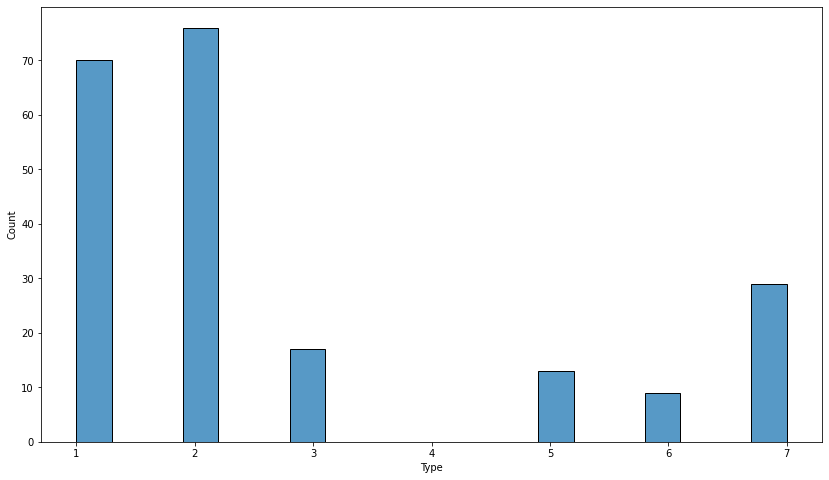

In [7]:
plt.figure(figsize=[14,8])
sns.histplot(df.Type, bins=6, binwidth=0.3)

Имеется дисбаланс классов в данных. Необходимо провести oversampling.

Заменим значения признаков Ba и Fe на категориальную переменную, где 0 - отсутствие, 1 - наличие.

In [8]:
df['Ba']=df['Ba'].apply(lambda x: 0 if x==0 else 1)
df['Fe']=df['Fe'].apply(lambda x: 0 if x==0 else 1)

# 3. Разделите выборку на обучающее и тестовое подмножество. 80% данных оставить на обучающее множество, 20% на тестовое.

In [9]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
X.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0,0
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0,0
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0,0
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0,0
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0,0


In [10]:
def train_test(X, y, train_size=0.8, random_state=42):
    return train_test_split(X, y, train_size=train_size, random_state=random_state)

In [11]:
X_train, X_test, y_train, y_test = train_test(X, y, train_size=0.8)
X_train.shape, X_test.shape

((171, 9), (43, 9))

# 4. Обучите модель дерева решений [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) на обучающем множестве.

In [12]:
random_forest = RandomForestClassifier(random_state=42, n_jobs=-1)
params = {'n_estimators': range(10,200,10),
          'max_features': ["sqrt", "log2", None] + list(range(0,8)),
         'class_weight': ["balanced", "balanced_subsample", None]}
grid = GridSearchCV(random_forest, params, n_jobs=-1, cv=5)
%time grid.fit(X_test, y_test)
grid.best_params_

CPU times: total: 5.84 s
Wall time: 2min 1s


{'class_weight': 'balanced', 'max_features': None, 'n_estimators': 140}

In [13]:
random_forest = RandomForestClassifier(n_estimators=grid.best_params_['n_estimators'],
                                       max_features=grid.best_params_['max_features'],
                                       class_weight=grid.best_params_['class_weight'], random_state=42, n_jobs=-1)
random_forest.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_features=None,
                       n_estimators=140, n_jobs=-1, random_state=42)

# 5. Для тестового множества предскажите тип стекла и сравните с истинным значением, посчитав точность предсказания модели (accuracy).

In [14]:
print(classification_report(y_test, random_forest.predict(X_test)))
baseline_score = classification_report(y_test, random_forest.predict(X_test), output_dict=True)

              precision    recall  f1-score   support

           1       0.71      0.91      0.80        11
           2       0.75      0.64      0.69        14
           3       1.00      0.67      0.80         3
           5       0.67      0.50      0.57         4
           6       1.00      1.00      1.00         3
           7       0.89      1.00      0.94         8

    accuracy                           0.79        43
   macro avg       0.84      0.79      0.80        43
weighted avg       0.79      0.79      0.78        43



# 6. Обработайте выбросы в данных.

### а) Визуализируйте распределение значений для каждой переменной. Можно использовать функции sns.boxplot, sns.distplot. Есть ли признаки с нормальным распределением?

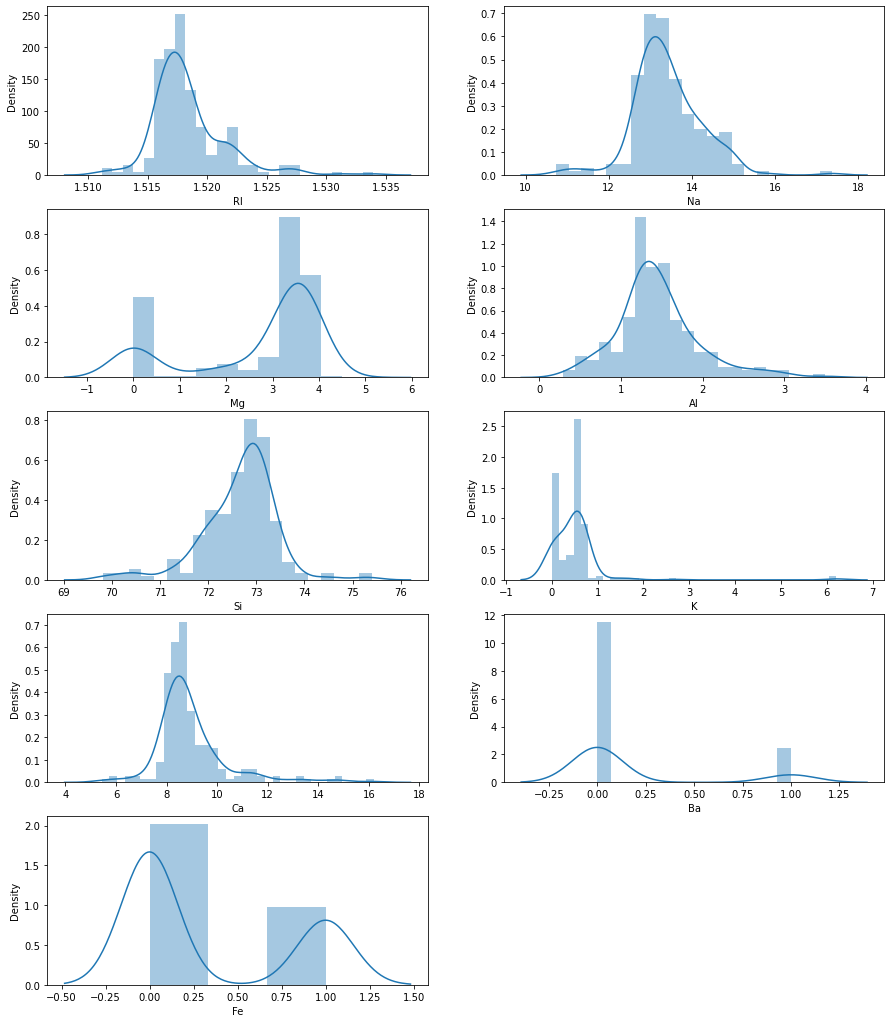

In [15]:
plt.figure(figsize=[15,18])

for i, j in zip(X.columns, range(len(X.columns))):
    plt.subplot(5, 2, j+1)
    sns.distplot(X[i])

В данных отсутствуют признаки с нормальным распределением. Распределение признака Al близко к нормальному.

### b) Исследуйте признаки на выбросы несколькими способами.

Т.к., в основном, данные распределены ненормально, не желательно искать выбросы по стандартному отклонению.
Воспользуемся другими методами.

**Метод межквартильного расстояния (Interquartile Range - IQR)**

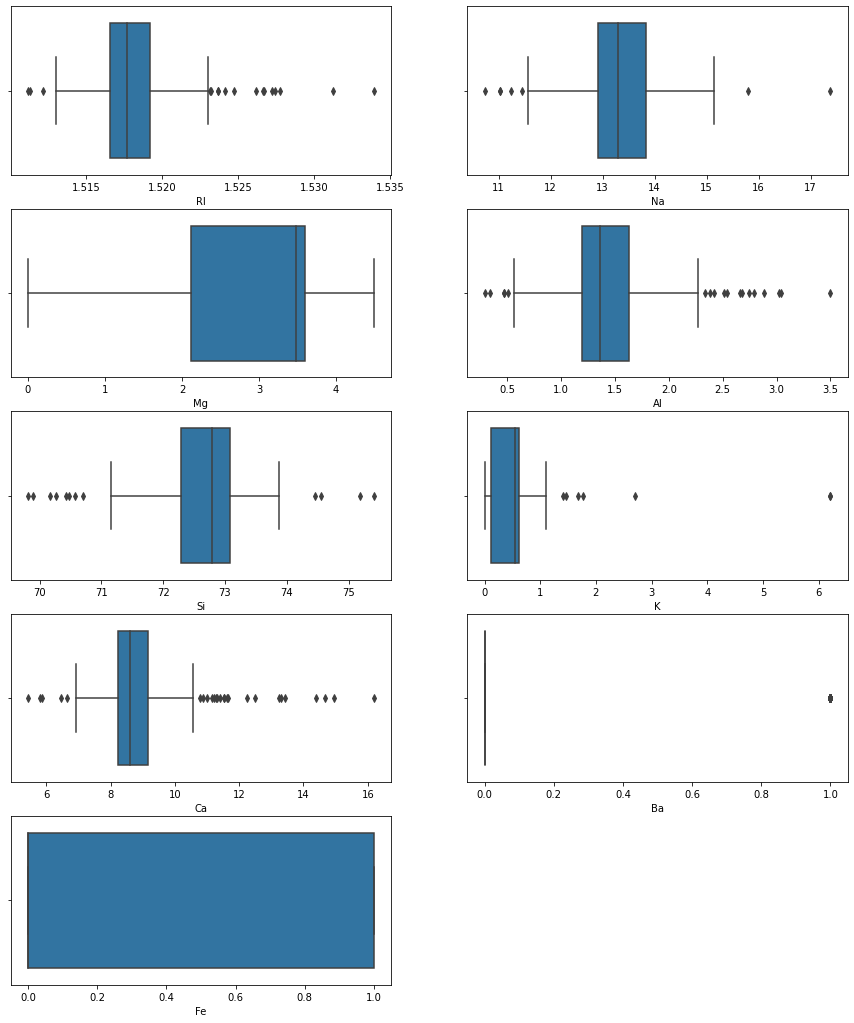

In [16]:
plt.figure(figsize=[15,18])

for i, j in zip(X.columns, range(len(X.columns))):
    plt.subplot(5, 2, j+1)
    sns.boxplot(X[i])

In [17]:
X_iqr = pd.DataFrame()

Q1 = X.quantile(q=.25)
Q3 = X.quantile(q=.75)
IQR = X.apply(stats.iqr)

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

X_iqr = X[(X >= lower_bound) & (X <= upper_bound)].dropna()
X_iqr.shape

(143, 9)

**Расстояние Махаланобиса.**

In [18]:
def mahalanobis(x=None, data=None, cov=None):

    x_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left = np.dot(x_mu, inv_covmat)
    mahal = np.dot(left, x_mu.T)
    return mahal.diagonal()

In [19]:
X['mahalanobis'] = mahalanobis(x=X, data=X[X.columns])
X['p'] = 1 - stats.chi2.cdf(X['mahalanobis'], X.shape[1] - 1)
X.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,mahalanobis,p
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0,0,4.841691,0.847884
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0,0,2.942888,0.966516
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0,0,2.089756,0.989967
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0,0,1.580980,0.996500
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0,0,1.995065,0.991545


Обычно выбросом считается p-значение меньше 0,001.

In [20]:
X_mah = X[X['p'] >= 0.001]
X = X.drop(['mahalanobis', 'p'], axis=1)
X_mah.shape

(205, 11)

**Модели.**

Поиск выбросов будем проводить с помощью моделей OneClassSVM, IsolationForest, LocalOutlierFactor и DBSCAN. Решение, считать ли данные выбросом, будем принимать исходя из результатов всех моделей.

In [21]:
def search_outliers(x, limit=0, logs=False):
    classifiers = {
    "OCSVM": OneClassSVM(nu=0.1), # nu - % выбросов
    "IsoForest": IsolationForest(random_state=42, n_jobs=-1),
    "LOF": LocalOutlierFactor(novelty=True, n_jobs=-1),
    "DBSCAN": DBSCAN(eps=2, min_samples=30, n_jobs=-1)
    }
    X_tmp = x.copy()
    X_tmp['out'] = 0
    
    for (clf_name, clf) in classifiers.items():
        clf.fit(x)
        if logs:
            print(clf_name)
        if clf_name == 'DBSCAN':
            X_tmp['out'] += clf.labels_
            if logs:
                print(clf.labels_, np.unique(clf.labels_))
        else:
            X_tmp['out'] += clf.predict(x)
            if logs:
                print(clf.predict(x))
        
    X_clast = X_tmp.loc[X_tmp['out'] > limit].copy() # Установив значениe limit можно увеличить или уменьшить число найденных выбросов
    return X_clast

In [22]:
def search_limit(x):
    
    best_limit = None
    best_score = 0

    for lim in range(-5, 3):
        X_clast = search_outliers(x, limit=lim, logs=False)
        data = X_clast.merge(df['Type'], how='left', left_index=True, right_index=True).drop('out', axis=1)

        X_new = data.iloc[:, :-1]
        y_new = data.iloc[:, -1]
        X_train, X_test, y_train, y_test = train_test(X_new, y_new, train_size=0.8)

        random_forest_ = RandomForestClassifier(n_estimators=grid.best_params_['n_estimators'],
                                           max_features=grid.best_params_['max_features'],
                                           class_weight=grid.best_params_['class_weight'], random_state=42, n_jobs=-1)
        random_forest_.fit(X_train, y_train)
        score = random_forest_.score(X_test, y_test)

        if best_score < score:
            best_score = score
            best_limit = lim
        print(f'lim={lim}, Score: {score}')

    print(f'limit={best_limit}, Score: {best_score}')
    return best_limit

In [23]:
X_clast = search_outliers(X, limit=search_limit(X))
X_clast.shape

lim=-5, Score: 0.7906976744186046
lim=-4, Score: 0.7560975609756098
lim=-3, Score: 0.7073170731707317
lim=-2, Score: 0.8461538461538461
lim=-1, Score: 0.8157894736842105
lim=0, Score: 0.8378378378378378
lim=1, Score: 0.7647058823529411
lim=2, Score: 0.6896551724137931
limit=-2, Score: 0.8461538461538461


(191, 10)

Возьмем за основу результаты поиска выбросов при помощи моделей.

### c) Удалите выбросы. Посчитайте процент удаленных записей от общего числа записей для каждого класса.

In [24]:
full_c = df.Type.value_counts()

In [25]:
data = X_clast.merge(df['Type'], how='left', left_index=True, right_index=True).drop('out', axis=1)
data.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0,0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0,0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0,0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0,0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0,0,1


In [26]:
cut_c = data.Type.value_counts()
cut_c

1    70
2    65
7    23
3    17
5     9
6     7
Name: Type, dtype: int64

<AxesSubplot:xlabel='Type', ylabel='Count'>

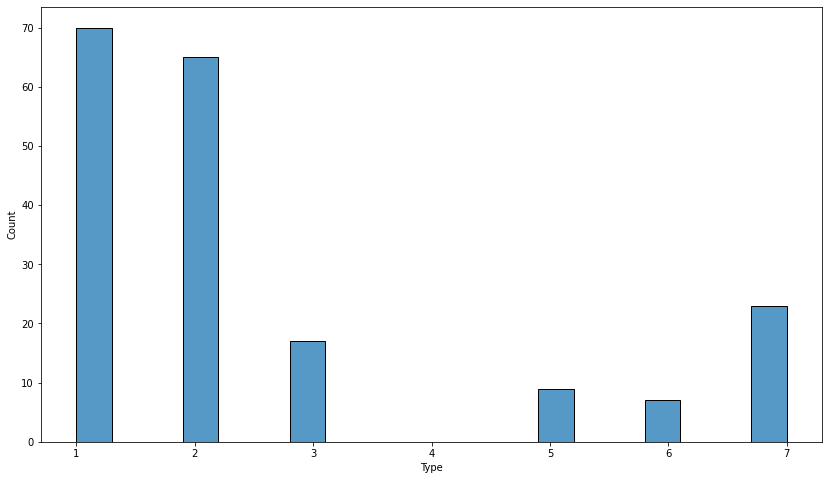

In [27]:
plt.figure(figsize=[14,8])
sns.histplot(data.Type, bins=6, binwidth=0.3)

In [28]:
print('Процент удаленных записей\n', (full_c - cut_c)*100 / full_c, sep='')

Процент удаленных записей
1     0.000000
2    14.473684
3     0.000000
5    30.769231
6    22.222222
7    20.689655
Name: Type, dtype: float64


In [29]:
X_new = data.iloc[:, :-1]
y_new = data.iloc[:, -1]

In [30]:
X_train, X_test, y_train, y_test = train_test(X_new, y_new, train_size=0.8)
rf = RandomForestClassifier(n_estimators=grid.best_params_['n_estimators'],
                                           max_features=grid.best_params_['max_features'],
                                           class_weight=grid.best_params_['class_weight'], random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
outliers_score = classification_report(y_test, rf.predict(X_test), output_dict=True)
print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           1       0.92      0.75      0.83        16
           2       0.83      0.91      0.87        11
           3       0.00      0.00      0.00         1
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         4

    accuracy                           0.85        39
   macro avg       0.79      0.78      0.78        39
weighted avg       0.90      0.85      0.87        39



Проведем oversampling.

In [31]:
oversampling = SMOTE(sampling_strategy='all', random_state=42, n_jobs=-1)
X_new, y_new = oversampling.fit_resample(X_new, y_new)

<AxesSubplot:xlabel='Type', ylabel='Count'>

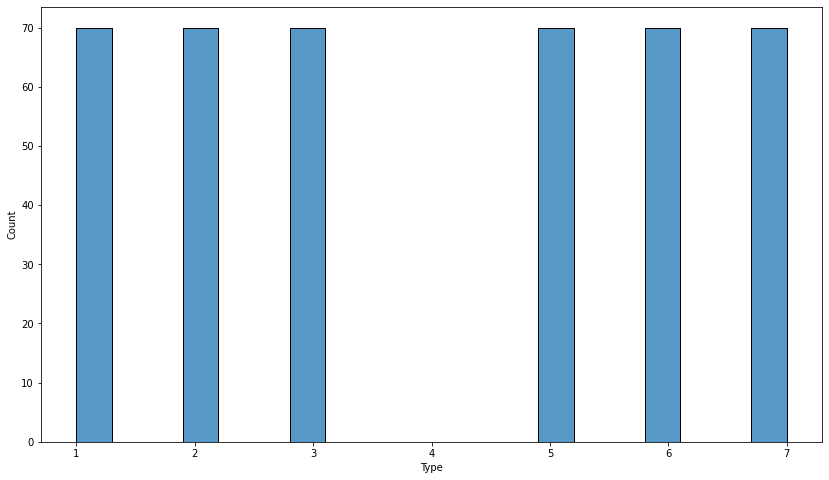

In [32]:
plt.figure(figsize=[14,8])
sns.histplot(y_new, bins=6, binwidth=0.3)

In [33]:
X_train, X_test, y_train, y_test = train_test(X_new, y_new, train_size=0.8)
rf = RandomForestClassifier(n_estimators=grid.best_params_['n_estimators'],
                                           max_features=grid.best_params_['max_features'],
                                           class_weight=grid.best_params_['class_weight'], random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
oversampling_score = classification_report(y_test, rf.predict(X_test), output_dict=True)
print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           1       0.86      0.75      0.80        16
           2       0.94      0.79      0.86        19
           3       0.62      1.00      0.77        10
           5       1.00      1.00      1.00        11
           6       1.00      1.00      1.00        14
           7       1.00      0.93      0.96        14

    accuracy                           0.89        84
   macro avg       0.90      0.91      0.90        84
weighted avg       0.91      0.89      0.90        84



Проверим эффективность преобразования признаков.

In [34]:
def square(x):
    '''Возведение в квадрат'''
    return x ** 2

In [35]:
def log(x):
    '''Логарифмирование'''
    return np.log(x+1e-20) # Добавляем значение, близкое к нулю, для исключение ошибкок при вычислении

In [36]:
def root(x):
    '''Квадратный корень'''
    return x ** 0.5

In [37]:
def transform_col(x, col, foo, arg):
    '''Применение трансформации к столбцу'''
    if arg == 'normalize':
        x[col] = normalize(x[[col]])
    else:
        x[col] = x[col].apply(foo[arg])
    return x[col]

In [38]:
def search_transform(X, cols=X.columns, flag=False):
    '''Проверка влияния трансформаций на метрику accuracy с учетом кросс-валидации'''
    # Номализация
    mm_scaler = MinMaxScaler()
    qt = QuantileTransformer()
    s_scaler = StandardScaler()
    
    # Словарь с преобразованиями
    math_transforms = {'nothing': lambda x: x, 'square': square, 'log': log, 'root': root,
                       'min_max_scaler': mm_scaler, 'quantile_transformer': qt,
                       'standart_scaler': s_scaler, 'normalize': normalize}

    for col in cols: # Перебор признаков
        
        best_score = 0
        best_transform = None
        
        for transform in math_transforms.keys(): # Перебор преобразований
                        
            tmp_X = X.copy()
            
            # Разделение нормализации и математических преобразований ввиду различного синтаксиса
            if transform in ['min_max_scaler', 'quantile_transformer', 'standart_scaler']: 
                tmp_X[col] = math_transforms[transform].fit_transform(tmp_X[[col]])
            else:
                tmp_X[col] = transform_col(tmp_X, col, math_transforms, transform)
            
            X_train, X_test, y_train, y_test = train_test(tmp_X, y_new, train_size=0.8)
            
            # Модель, с учетом подобранных оптимальных параметров
            random_forest = RandomForestClassifier(n_estimators=grid.best_params_['n_estimators'],
                                       max_features=grid.best_params_['max_features'],
                                       class_weight=grid.best_params_['class_weight'], random_state=42, n_jobs=-1)
            random_forest.fit(X_train, y_train)
            score = random_forest.score(X_test, y_test)
            
            if best_score < score:
                best_score = score
                best_transform = transform
        
        # Преобразование признаков
        if best_transform in ['min_max_scaler', 'quantile_transformer', 'standart_scaler']:
            X[col] = math_transforms[best_transform].fit_transform(X[[col]])
        else:
            transform_col(X, col, math_transforms, best_transform)
        print(f'{col} - {best_transform}: best_score - {best_score}')
        
    if flag:
        return X

In [39]:
X_new = search_transform(X_new, flag=True)

RI - nothing: best_score - 0.8928571428571429
Na - nothing: best_score - 0.8928571428571429
Mg - nothing: best_score - 0.8928571428571429
Al - nothing: best_score - 0.8928571428571429
Si - nothing: best_score - 0.8928571428571429
K - nothing: best_score - 0.8928571428571429
Ca - nothing: best_score - 0.8928571428571429
Ba - nothing: best_score - 0.8928571428571429
Fe - nothing: best_score - 0.8928571428571429


Преобразования нецелесообразны.

# 7. Повторите п. 4, п. 5.

In [40]:
X_train, X_test, y_train, y_test = train_test(X_new, y_new, train_size=0.8)

In [41]:
random_forest_ = RandomForestClassifier(random_state=42, n_jobs=-1)
params = {'n_estimators': range(10,200,10),
          'max_features': ["sqrt", "log2", None] + list(range(0,8)),
          'class_weight': ["balanced", "balanced_subsample", None]}
grid = GridSearchCV(random_forest_, params, n_jobs=-1, cv=5)
%time grid.fit(X_test, y_test) # Подбор оптимальных параметров модели
grid.best_params_

CPU times: total: 5.27 s
Wall time: 1min 53s


{'class_weight': 'balanced_subsample',
 'max_features': 'sqrt',
 'n_estimators': 140}

In [42]:
random_forest_ = RandomForestClassifier(n_estimators=grid.best_params_['n_estimators'],
                                       max_features=grid.best_params_['max_features'],
                                       class_weight=grid.best_params_['class_weight'], random_state=42, n_jobs=-1)
random_forest_.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_features='sqrt',
                       n_estimators=140, n_jobs=-1, random_state=42)

In [43]:
cross_val_score(random_forest_, X_test, y_test, cv=5, n_jobs=-1)

array([0.94117647, 0.82352941, 0.94117647, 0.82352941, 0.875     ])

In [44]:
np.mean(cross_val_score(random_forest_, X_test, y_test, cv=5, n_jobs=-1))

0.8808823529411764

In [45]:
print(classification_report(y_test, random_forest_.predict(X_test)))

              precision    recall  f1-score   support

           1       0.87      0.81      0.84        16
           2       1.00      0.84      0.91        19
           3       0.67      1.00      0.80        10
           5       1.00      1.00      1.00        11
           6       1.00      1.00      1.00        14
           7       1.00      0.93      0.96        14

    accuracy                           0.92        84
   macro avg       0.92      0.93      0.92        84
weighted avg       0.93      0.92      0.92        84



Видно много ложноположительных результатов для класса 3. Скорректируем порог вероятности для этого класса.

In [46]:
def classification(predict_proba, col, coef):
    res = []
    for probs in predict_proba:
        probs[col] -= coef
        max_prob = max(probs)
        
        # Т.к. в данных указаны классы 1,2,3,5,6,7, то скорректируем значиния индексов для корректного отображения классов
        if list(probs).index(max_prob) < 3:
            res.append(list(probs).index(max_prob) + 1)
        else:
            res.append(list(probs).index(max_prob) + 2)

    return res

In [47]:
final_score = classification_report(y_test, classification(random_forest_.predict_proba(X_test), 2, 0.4), output_dict=True)
print(classification_report(y_test, classification(random_forest_.predict_proba(X_test), 2, 0.4)))

              precision    recall  f1-score   support

           1       0.84      1.00      0.91        16
           2       1.00      0.84      0.91        19
           3       0.91      1.00      0.95        10
           5       1.00      1.00      1.00        11
           6       1.00      1.00      1.00        14
           7       1.00      0.93      0.96        14

    accuracy                           0.95        84
   macro avg       0.96      0.96      0.96        84
weighted avg       0.96      0.95      0.95        84



In [48]:
classification_report(y_test, classification(random_forest_.predict_proba(X_test), 2, 0.4), output_dict=True)

{'1': {'precision': 0.8421052631578947,
  'recall': 1.0,
  'f1-score': 0.9142857142857143,
  'support': 16},
 '2': {'precision': 1.0,
  'recall': 0.8421052631578947,
  'f1-score': 0.9142857142857143,
  'support': 19},
 '3': {'precision': 0.9090909090909091,
  'recall': 1.0,
  'f1-score': 0.9523809523809523,
  'support': 10},
 '5': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 11},
 '6': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 14},
 '7': {'precision': 1.0,
  'recall': 0.9285714285714286,
  'f1-score': 0.962962962962963,
  'support': 14},
 'accuracy': 0.9523809523809523,
 'macro avg': {'precision': 0.9585326953748007,
  'recall': 0.961779448621554,
  'f1-score': 0.9573192239858906,
  'support': 84},
 'weighted avg': {'precision': 0.9591023012075643,
  'recall': 0.9523809523809523,
  'f1-score': 0.9524439405391786,
  'support': 84}}

# 8. Сформулируйте выводы по проделанной работе.
### а) Кратко опишите, какие преобразования были сделаны с данными.

В данных, на основании совокупности результатов алгоритмов были удалены выбросы. Так же проведен оверсэмплинг с целью устранения дисбаланса классов.

### b) Сравните точность двух моделей.

In [49]:
arrays = [('baseline', 'precision'), ('baseline', 'recall'),
          ('drop_outliers', 'precision'), ('drop_outliers', 'recall'),
          ('oversampling', 'precision'), ('oversampling', 'recall'),
          ('final', 'precision'), ('final', 'recall')]

index = pd.MultiIndex.from_tuples(arrays, names=["Model", "Metric"])
columns = ['weighted avg', '1', '2', '3', '5', '6', '7']

res = np.array([[baseline_score['weighted avg']['precision'], baseline_score['1']['precision'],
                 baseline_score['2']['precision'], baseline_score['3']['precision'],
                 baseline_score['5']['precision'], baseline_score['6']['precision'], baseline_score['7']['precision']],
                
                [baseline_score['weighted avg']['recall'], baseline_score['1']['recall'],
                 baseline_score['2']['recall'], baseline_score['3']['recall'], baseline_score['5']['recall'],
                 baseline_score['6']['recall'], baseline_score['7']['recall']],
                
                [outliers_score['weighted avg']['precision'], outliers_score['1']['precision'],
                 outliers_score['2']['precision'], outliers_score['3']['precision'], outliers_score['5']['precision'],
                 outliers_score['6']['precision'], outliers_score['7']['precision']],
                
                [outliers_score['weighted avg']['recall'], outliers_score['1']['recall'],
                 outliers_score['2']['recall'], outliers_score['3']['recall'], outliers_score['5']['recall'],
                 outliers_score['6']['recall'], outliers_score['7']['recall']],
                
                [oversampling_score['weighted avg']['precision'], oversampling_score['1']['precision'],
                 oversampling_score['2']['precision'], oversampling_score['3']['precision'], 
                 oversampling_score['5']['precision'], oversampling_score['6']['precision'],
                 oversampling_score['7']['precision']],
                
                [oversampling_score['weighted avg']['recall'], oversampling_score['1']['recall'],
                 oversampling_score['2']['recall'], oversampling_score['3']['recall'], oversampling_score['5']['recall'],
                 oversampling_score['6']['recall'], oversampling_score['7']['recall']],
                
                [final_score['weighted avg']['precision'], final_score['1']['precision'],
                 final_score['2']['precision'], final_score['3']['precision'], final_score['5']['precision'],
                 final_score['6']['precision'], final_score['7']['precision']],
                
                [final_score['weighted avg']['recall'], final_score['1']['recall'],
                 final_score['2']['recall'], final_score['3']['recall'], final_score['5']['recall'],
                 final_score['6']['recall'], final_score['7']['recall']]
])
pd.DataFrame(res.T, index=columns, columns=index)

Model         baseline           drop_outliers           oversampling  \
Metric       precision    recall     precision    recall    precision   
weighted avg  0.793835  0.790698      0.895792  0.846154     0.914009   
1             0.714286  0.909091      0.923077  0.750000     0.857143   
2             0.750000  0.642857      0.833333  0.909091     0.937500   
3             1.000000  0.666667      0.000000  0.000000     0.625000   
5             0.666667  0.500000      1.000000  1.000000     1.000000   
6             1.000000  1.000000      1.000000  1.000000     1.000000   
7             0.888889  1.000000      1.000000  1.000000     1.000000   

Model                      final            
Metric          recall precision    recall  
weighted avg  0.892857  0.959102  0.952381  
1             0.750000  0.842105  1.000000  
2             0.789474  1.000000  0.842105  
3             1.000000  0.909091  1.000000  
5             1.000000  1.000000  1.000000  
6             1.000000  1.000000  1.000000  
7             0.928571  1.000000  0.928571

### c) Напишите свое мнение, нужно ли исследовать данные на выбросы, для чего это делается, плюсы и минусы подхода.

Исследование данных на выбросы - это важный этап предобработки данных, который позволяет выявить и обработать значения, сильно отличающиеся от остальных в наборе данных.

Основная цель исследования на выбросы - это выявление потенциальных ошибок в данных, таких как опечатки, ошибки при вводе данных, ошибки при измерении, аномальные значения, которые не соответствуют ожидаемому диапазону. Если выбросы не обработать, они могут значительно повлиять на результаты анализа данных и привести к ошибочным выводам.

Одним из плюсов исследования данных на выбросы является возможность улучшить качество модели машинного обучения. Выбросы могут оказывать значительное влияние на обучение модели, поскольку многие алгоритмы машинного обучения чувствительны к выбросам. Обработка выбросов может привести к улучшению точности модели.